# Improvement to Bayesian 

In [ ]:
from __future__ import division

import gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow.contrib.slim as slim

### Load the environment

In [6]:
env = gym.make('CartPole-v0')

## The Deep Q-Network 

### Helper functions

In [7]:
class experience_buffer():
    def __init__(self, buffer_size = 10000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
            
    def sample(self,size):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])
    
def updateTargetGraph(tfVars,tau):
    total_vars = len(tfVars)
    op_holder = []
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau) + ((1-tau)*tfVars[idx+total_vars//2].value())))
    return op_holder

def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)

### Implementing the network itself

In [8]:
class Q_Network():
    def __init__(self):
        #These lines establish the feed-forward part of the network used to choose actions
        self.inputs = tf.placeholder(shape=[None,4],dtype=tf.float32)
        self.Temp = tf.placeholder(shape=None,dtype=tf.float32)
        self.keep_per = tf.placeholder(shape=None,dtype=tf.float32)

        hidden = slim.fully_connected(self.inputs,64,activation_fn=tf.nn.tanh,biases_initializer=None)
        hidden = slim.dropout(hidden,self.keep_per)
        self.Q_out = slim.fully_connected(hidden,2,activation_fn=None,biases_initializer=None)
        
        self.predict = tf.argmax(self.Q_out,1)
        self.Q_dist = tf.nn.softmax(self.Q_out/self.Temp)
        
        
        #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,2,dtype=tf.float32)
        
        self.Q = tf.reduce_sum(tf.multiply(self.Q_out, self.actions_onehot), reduction_indices=1)
        
        self.nextQ = tf.placeholder(shape=[None],dtype=tf.float32)
        loss = tf.reduce_sum(tf.square(self.nextQ - self.Q))
        trainer = tf.train.GradientDescentOptimizer(learning_rate=0.0005)
        self.updateModel = trainer.minimize(loss)

### Training the network

In [9]:
# Set learning parameters
exploration = "e-greedy" #Exploration method. Choose between: greedy, random, e-greedy, boltzmann, bayesian.
y = .99 #Discount factor.
num_episodes = 20000 #Total number of episodes to train network for.
tau = 0.001 #Amount to update target network at each step.
batch_size = 32 #Size of training batch
startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
anneling_steps = 200000 #How many steps of training to reduce startE to endE.
pre_train_steps = 50000 #Number of steps used before training updates begin.

In [10]:
def choice(exploration):
    tf.reset_default_graph()

    q_net = Q_Network()
    target_net = Q_Network()

    init = tf.initialize_all_variables()
    trainables = tf.trainable_variables()
    targetOps = updateTargetGraph(trainables,tau)
    myBuffer = experience_buffer()


    #create lists to contain total rewards and steps per episode
    jList = []
    jMeans = []
    rList = []
    rMeans = []
    with tf.Session() as sess:
        sess.run(init)
        updateTarget(targetOps,sess)
        e = startE
        stepDrop = (startE - endE)/anneling_steps
        total_steps = 0

        for i in range(num_episodes):
            s = env.reset()
            rAll = 0
            d = False
            j = 0
            while j < 999:
                j+=1
                if exploration == "greedy":
                    #Choose an action with the maximum expected value.
                    a,allQ = sess.run([q_net.predict,q_net.Q_out],feed_dict={q_net.inputs:[s],q_net.keep_per:1.0})
                    a = a[0]
                if exploration == "random":
                    #Choose an action randomly.
                    a = env.action_space.sample()
                if exploration == "e-greedy":
                    #Choose an action by greedily (with e chance of random action) from the Q-network
                    if np.random.rand(1) < e or total_steps < pre_train_steps:
                        a = env.action_space.sample()
                    else:
                        a,allQ = sess.run([q_net.predict,q_net.Q_out],feed_dict={q_net.inputs:[s],q_net.keep_per:1.0})
                        a = a[0]
                if exploration == "boltzmann":
                    #Choose an action probabilistically, with weights relative to the Q-values.
                    Q_d,allQ = sess.run([q_net.Q_dist,q_net.Q_out],feed_dict={q_net.inputs:[s],q_net.Temp:e,q_net.keep_per:1.0})
                    a = np.random.choice(Q_d[0],p=Q_d[0])
                    a = np.argmax(Q_d[0] == a)
                if exploration == "bayesian":
                    #Choose an action using a sample from a dropout approximation of a bayesian q-network.
                    a,allQ = sess.run([q_net.predict,q_net.Q_out],feed_dict={q_net.inputs:[s],q_net.keep_per:(1-e)+0.1})
                    a = a[0]
                if exploration == "bayesian_Improvised":
                    #Choose an action using a sample from a dropout approximation of a bayesian q-network.
                    a,allQ = sess.run([q_net.predict,q_net.Q_out],feed_dict={q_net.inputs:[s],q_net.keep_per:(1-np.sqrt(e))+0.01})
                    a = a[0]

                #Get new state and reward from environment
                s1,r,d,_ = env.step(a)
                myBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5]))

                if e > endE and total_steps > pre_train_steps:
                    e -= stepDrop

                if total_steps > pre_train_steps and total_steps % 5 == 0:
                    #We use Double-DQN training algorithm
                    trainBatch = myBuffer.sample(batch_size)
                    Q1 = sess.run(q_net.predict,feed_dict={q_net.inputs:np.vstack(trainBatch[:,3]),q_net.keep_per:1.0})
                    Q2 = sess.run(target_net.Q_out,feed_dict={target_net.inputs:np.vstack(trainBatch[:,3]),target_net.keep_per:1.0})
                    end_multiplier = -(trainBatch[:,4] - 1)
                    doubleQ = Q2[range(batch_size),Q1]
                    targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                    _ = sess.run(q_net.updateModel,feed_dict={q_net.inputs:np.vstack(trainBatch[:,0]),q_net.nextQ:targetQ,q_net.keep_per:1.0,q_net.actions:trainBatch[:,1]})
                    updateTarget(targetOps,sess)

                rAll += r
                s = s1
                total_steps += 1
                if d == True:
                    break
            jList.append(j)
            rList.append(rAll)
            if i % 100 == 0 and i != 0:
                r_mean = np.mean(rList[-100:])
                j_mean = np.mean(jList[-100:])
                if exploration == 'e-greedy':
                    print("Mean Reward: " + str(r_mean) + " Total Steps: " + str(total_steps) + " e: " + str(e))
                if exploration == 'boltzmann':
                    print("Mean Reward: " + str(r_mean) + " Total Steps: " + str(total_steps) + " t: " + str(e))
                if exploration == 'bayesian':
                    print("Mean Reward: " + str(r_mean) + " Total Steps: " + str(total_steps) + " p: " + str(e))
                if exploration == 'bayesian1':
                    print("Mean Reward: " + str(r_mean) + " Total Steps: " + str(total_steps) + " p: " + str(e))
                if exploration == 'random' or exploration == 'greedy':
                    print("Mean Reward: " + str(r_mean) + " Total Steps: " + str(total_steps))
                rMeans.append(r_mean)
                jMeans.append(j_mean)
    print("/n ***********************/nPercent of succesful episodes: " + str(sum(rList)/num_episodes) + "%" + "Exploration Approach "+exploration)
    return(rMeans, jMeans)

### Some statistics on network performance

In [11]:
bayesian_rmeans, bayesian_jmeans = choice("bayesian")
bayesian1_rmeans, bayesian1_jmeans = choice("bayesian_Improvised")
#Exploration method


#plt.plot(rMeans)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Mean Reward: 31.17 Total Steps: 3168 p: 1
Mean Reward: 30.95 Total Steps: 6263 p: 1
Mean Reward: 32.84 Total Steps: 9547 p: 1
Mean Reward: 30.55 Total Steps: 12602 p: 1
Mean Reward: 32.2 Total Steps: 15822 p: 1
Mean Reward: 32.21 Total Steps: 19043 p: 1
Mean Reward: 34.74 Total Steps: 22517 p: 1
Mean Reward: 33.61 Total Steps: 25878 p: 1
Mean Reward: 30.57 Total Steps: 28935 p: 1
Mean Reward: 32.73 Total Steps: 32208 p: 1
Mean Reward: 32.83 Total Steps: 35491 p: 1
Mean Reward: 30.94 Total Steps: 38585 p: 1
Mean Reward: 28.27 Total Steps: 41412 p: 1
Mean Reward: 29.23 Total Steps: 44335 p: 1
Mean Reward: 30.78 Total Steps: 47413 p: 1
Mean Reward: 34.03 Total Steps: 50816 p: 0.9963325

Mean Reward: 101.8 Total Steps: 524523 p: 0.09999550000334036
Mean Reward: 98.94 Total Steps: 534417 p: 0.09999550000334036
Mean Reward: 95.88 Total Steps: 544005 p: 0.09999550000334036
Mean Reward: 96.16 Total Steps: 553621 p: 0.09999550000334036
Mean Reward: 98.74 Total Steps: 563495 p: 0.09999550000334036
Mean Reward: 96.46 Total Steps: 573141 p: 0.09999550000334036
Mean Reward: 99.8 Total Steps: 583121 p: 0.09999550000334036
Mean Reward: 92.41 Total Steps: 592362 p: 0.09999550000334036
Mean Reward: 94.56 Total Steps: 601818 p: 0.09999550000334036
Mean Reward: 99.06 Total Steps: 611724 p: 0.09999550000334036
Mean Reward: 95.56 Total Steps: 621280 p: 0.09999550000334036
Mean Reward: 100.4 Total Steps: 631320 p: 0.09999550000334036
Mean Reward: 99.93 Total Steps: 641313 p: 0.09999550000334036
Mean Reward: 97.54 Total Steps: 651067 p: 0.09999550000334036
Mean Reward: 105.63 Total Steps: 661630 p: 0.09999550000334036
Mean Reward: 100.59 Total Steps: 671689 p: 0.09999550000334036
Mean Re

Text(0, 0.5, 'Episodes')

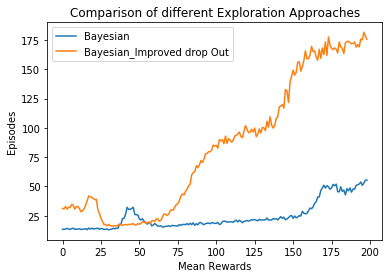

In [16]:
plt.plot(bayesian1_rmeans)
plt.plot(bayesian_rmeans)
plt.legend(['Bayesian', 'Bayesian_Improved drop Out'], loc='upper left')
plt.title('Comparison of different Exploration Approaches')
plt.xlabel('Mean Rewards')
plt.ylabel('Episodes')